## Solving Cliff-Walking Environment with TD Control

Kenechi Franklin Dukor

Special thanks to Facebook-Pytorch and Udacity

#### Lets import the needed packages

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Lets create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment provided by `openai gym`

In [2]:
env = gym.make('CliffWalking-v0')

In [3]:
print(env.observation_space)
print(env.action_space)

Discrete(48)
Discrete(4)


The agent has 48 observation space (states) and 4 possible action

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through to `46`.

The agent gets a reward of `-100`, if hits a cliff, and `-1` for every other state. The agent must reach the termainal state in the least possible time while the rewards are still maximised.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

### Exploring Random Policies
Lets test the cliff walking environment with some random policy.

In [4]:
episode = []
state = env.reset()

for movement in range(10):
    action = env.action_space.sample()

    next_state, reward, done, info = env.step(action)

    episode.append((state, action, reward))
    print("State: ", state, "\tAction: ", action, "\tReward: ", reward, "\tNext state: ", next_state)
    state = next_state

#     if done:
#         break

State:  36 	Action:  0 	Reward:  -1 	Next state:  24
State:  24 	Action:  1 	Reward:  -1 	Next state:  25
State:  25 	Action:  1 	Reward:  -1 	Next state:  26
State:  26 	Action:  0 	Reward:  -1 	Next state:  14
State:  14 	Action:  0 	Reward:  -1 	Next state:  2
State:  2 	Action:  0 	Reward:  -1 	Next state:  2
State:  2 	Action:  0 	Reward:  -1 	Next state:  2
State:  2 	Action:  3 	Reward:  -1 	Next state:  1
State:  1 	Action:  0 	Reward:  -1 	Next state:  1
State:  1 	Action:  3 	Reward:  -1 	Next state:  0


#### Visualize the Optimal Policy
We will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

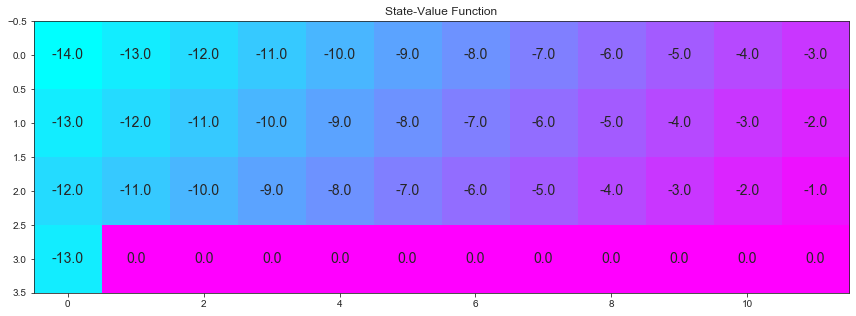

In [5]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0:13][0] = -np.arange(3, 15)[::-1]
V_opt[0:13][1] = -np.arange(3, 15)[::-1] + 1
V_opt[0:13][2] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### TD Control: Sarsa(0) Method

<p align="center">
  <img src="images/td_1.png" width="700" title="hover text">

</p>

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.


In [65]:
def sarsa_0(env, num_episodes, alpha, gamma=1.0, eps_start=1, esp_decay=0.999, esp_limit=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    plot_every = 100
    tmp_scores = []
    scores = []
    
    nA = env.nA
    
    epsilon = eps_start
    # initialize performance monitor
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        # Observe the Space
        state = env.reset()  
            
        score = 0
        
        epsilon = max(epsilon * esp_decay, esp_limit)
        # notice that i didnt add epsilon to the get_eps_prob function. it didnt perform well. i needs to decy faster
        action = np.random.choice(np.arange(nA), p=get_eps_prob(nA, state, Q, i_episode))
        
        #Since we dont want the policy to jump to the next episode (we want it to learn well in each episode)
        
        for step in np.arange(300):
            next_state, reward, done, info = env.step(action)
            
            score += reward
            
            # Remember, we want to update the action-value before moving to the next state
            if not done:
                # notice that i didnt add epsilon to the get_eps_prob function. it didnt perform well. i needs to decy faster
                next_action = np.random.choice(np.arange(nA), p=get_eps_prob(nA, next_state, Q, i_episode))

                # lets get the action-value for the next state
                Q_next = Q[next_state][next_action]

                Q[state][action] = update_Q(gamma, alpha, Q[state][action], reward, Q_next)

                # Lets set next state to be current state (S <- S')
                state = next_state
                # Lets set next action to be current action (A <- A')
                action = next_action

            if done:
                # update TD estimate
                Q[state][action] = update_Q(gamma, alpha, Q[state][action], reward, 0)

                # append score
                tmp_scores.append(score)
                break
        
#         policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
        if (i_episode % plot_every == 0):
            scores.append(np.mean(tmp_scores))
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
    return Q

Lets define the required function

In [66]:
def get_eps_prob(nA, state, Q, i_episode, eps=None):
    if eps is not None:
        epsilon = eps
    else:
        epsilon = 1 / i_episode
        
    prob = np.ones(nA) * (epsilon / nA)
    
    # Get action from state
    if state in Q:
        prev_action = Q[state]
    else:
        prev_action = np.random.choice(np.arange(4), p=(np.ones(nA)/nA))
    
    # Get the position of the best action in the previous episode
    best_action_index = np.argmax(prev_action)
    prob[best_action_index] = (1 - epsilon) + (epsilon / nA)
    
    return prob

def update_Q(gamma, alpha, Q, reward, Q_next):
    
    Q = Q + (alpha * ((reward + (gamma*Q_next)) - Q))
    
    return Q

#### Train
Lets train and obtain the estimate the optimal policy

In [ ]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa_0(env, 6000, .01)

Lets print the estimated optimal policy and plot the estimated optimal state-value function

Episode 6000/6000

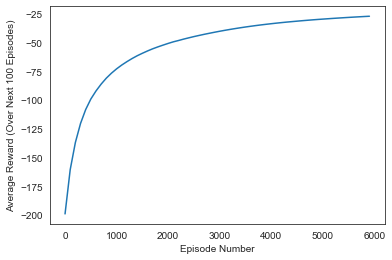

Best Average Reward over 100 Episodes:  -27.03979933110368


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 3  1  2  1  1  2  1  1  1  1  0  1]
 [ 0  0  1  1  1  1  2  1  2  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


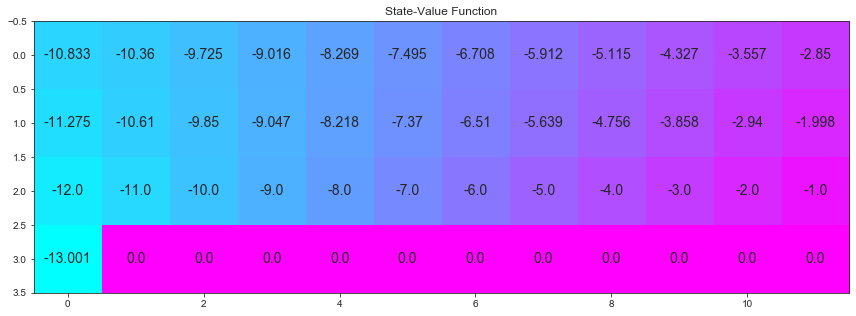

In [67]:
# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

#### Test
Lets test the policy

In [68]:
def Test(env, Q):
    state = env.reset()
    while True:
        if state in Q:
            policy = dict((k,np.argmax(v)) for k, v in Q.items())
            action = policy[state]
        else:
            action = env.action_space.sample()
            
        next_state, reward, done, info = env.step(action)

        episode.append((state, action, reward))
        print("State: ", state, "\tAction: ", action, "\tReward: ", reward, "\tNext state: ", next_state)
        state = next_state
        if done:
            break

In [69]:
Test(env, Q_sarsa)

State:  36 	Action:  0 	Reward:  -1 	Next state:  24
State:  24 	Action:  1 	Reward:  -1 	Next state:  25
State:  25 	Action:  1 	Reward:  -1 	Next state:  26
State:  26 	Action:  1 	Reward:  -1 	Next state:  27
State:  27 	Action:  1 	Reward:  -1 	Next state:  28
State:  28 	Action:  1 	Reward:  -1 	Next state:  29
State:  29 	Action:  1 	Reward:  -1 	Next state:  30
State:  30 	Action:  1 	Reward:  -1 	Next state:  31
State:  31 	Action:  1 	Reward:  -1 	Next state:  32
State:  32 	Action:  1 	Reward:  -1 	Next state:  33
State:  33 	Action:  1 	Reward:  -1 	Next state:  34
State:  34 	Action:  1 	Reward:  -1 	Next state:  35
State:  35 	Action:  2 	Reward:  -1 	Next state:  47


### TD Control: Q-learning (a.k.a Sarsamax)

<p align="center">
  <img src="images/td_2.png" width="700" title="hover text">

</p>

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

### TD Control: Expected Sarsa

<p align="center">
  <img src="images/td_3.png" width="700" title="hover text">

</p>

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.